<a href="https://colab.research.google.com/github/Armanskij/Projeto-SQL/blob/main/Projeto_SQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | SQL: Projeto
**Projeto**<br>
Professora [Mariane Neiva](https://www.linkedin.com/in/mariane-neiva/)
<br>
Tutora [Juliana Otsuka](https://www.linkedin.com/in/juliana-otsuka/)
<br>
Elaborado por [Douglas Rizzi](https://www.linkedin.com/in/douglas-rizzi/)


---

# Introdução


Este projeto tem como objetivo demonstrar a aplicação da linguagem [SQL](https://aws.amazon.com/pt/what-is/sql/) na análise de dados. Através deste estudo, buscamos utilizar essa poderosa linguagem para consultar um banco de dados, realizar análises rápidas e extrair insights valiosos.

O SQL é uma ferramenta essencial para qualquer analista de dados, oferecendo diversas interfaces de consulta, tanto em ambientes locais quanto na nuvem. Neste projeto, foi disponibilizado um arquivo CSV contendo dados de clientes de uma empresa de cartão de crédito. Com base nesses dados, exploraremos como realizar consultas eficientes em SQL e como integrar essas consultas com ferramentas de visualização de dados.

Ao longo do projeto, destacaremos a utilidade do SQL em diferentes contextos, desde a execução de consultas simples até a criação de tabelas complexas com dados agregados. Nossa intenção é demonstrar como o SQL pode ser utilizado para transformar dados brutos em informações acionáveis.

Além disso, uma vez que os dados forem tratados e analisados, utilizaremos ferramentas de visualização em Python, como Matplotlib e Seaborn, para apresentar os resultados de forma clara e intuitiva. Essas visualizações são fundamentais para interpretar e comunicar os resultados das análises de maneira eficaz.

Em resumo, este projeto visa não apenas mostrar a versatilidade e eficiência do SQL na análise de dados, mas também a importância da integração com ferramentas de visualização para proporcionar uma compreensão mais profunda e visual dos dados analisados. Com isso, esperamos fornecer uma visão abrangente do processo de análise de dados, desde a consulta inicial até a apresentação final dos resultados.

# Coleta dos dados

A origem dos dados deste projeto é um arquivo do tipo CSV, disponibilizado no curso de analista de dados da EBAC. Nele, utilizamos ferramentas de *Cloud* para armazenar, carregar e analisar dados, como por exemplo o AWS S3 (para armazenamento de arquivos) e o AWS Athena (interface onde realizamos *queries*), ambos serviços da Amazon. Esses serviços proporcionam um ótimo ambiente de trabalho, pois, em um só lugar, podemos encontrar diversos produtos para solucionar tanto demandas da área de dados quanto de TI em geral, sendo eles altamente seguros e escalonáveis.

Carreguei o arquivo do projeto em um *bucket* do S3 e configurei o acesso para que se tornasse público (seguindo as diretrizes da [LGPD](https://www.planalto.gov.br/ccivil_03/_ato2015-2018/2018/lei/l13709.htm). Dessa forma, ele pode ser carregado via *notebook* Python para esta análise.

In [ ]:
!pip install boto3

In [1]:
import json
import sqlite3
from io import StringIO

import boto3
import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns
from botocore import UNSIGNED
from botocore.client import Config
from IPython.display import Image, display
from matplotlib.patches import Patch
from tabulate import tabulate

ModuleNotFoundError: No module named 'boto3'

Com o arquivo já alocado e configurado na nuvem, podemos carregá-lo e iniciar as consultas.

É importante destacar que, geralmente, as consultas SQL são realizadas em ambientes específicos, como MySQL, SQLite, Oracle, ou PostgreSQL. No contexto da AWS, o serviço [Athena](https://aws.amazon.com/pt/athena/) permite realizar consultas diretamente em arquivos armazenados no S3, proporcionando uma solução eficiente para a análise de dados.

No entanto, para este projeto, optei por emular um banco de dados e um console virtual. Utilizando as bibliotecas [Boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) e [sqlite3](https://docs.python.org/3/library/sqlite3.html), consegui carregar o arquivo CSV e criar um banco de dados local, permitindo a execução de consultas diretamente no notebook Jupyter. Essa abordagem foi escolhida para evitar a necessidade de múltiplas capturas de tela para documentar as etapas realizadas no Athena, tornando o processo mais interativo e fluido.

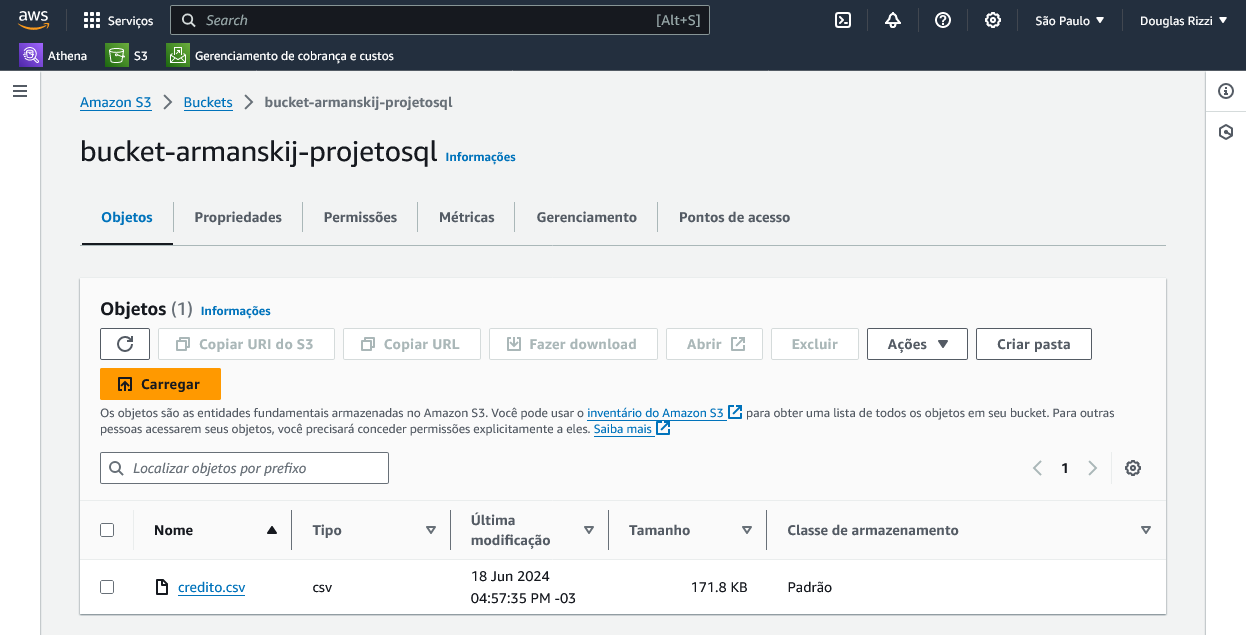

In [ ]:
url = "https://raw.githubusercontent.com/Armanskij/Projeto-SQL/172bef10eee3905616acac91dc1aabecf7747231/bucket-origem.png"
response = requests.get(url)

if response.status_code == 200:
    display(Image(response.content))
else:
    print(f"Erro ao baixar a imagem: {response.status_code}")

In [ ]:
# configurando o boto3 para acessar o Amazon S3
s3 = boto3.resource('s3', config=Config(signature_version=UNSIGNED))

In [ ]:
# definindo os parâmetros para encontrar o arquivo
s3_client = boto3.client('s3')
bucket_name = 'bucket-armanskij-projetosql'
file_key = 'credito.csv'
object_ulr = 'https://bucket-armanskij-projetosql.s3.sa-east-1.amazonaws.com/credito.csv'

In [ ]:
# usando requests para baixar o arquivo
response = requests.get(object_ulr)

if response.status_code == 200:
  with open (file_key, 'wb') as f:
    f.write(response.content)
  print ('Arquivo carregado com sucesso.')
else:
  print('Falha ao carregar arquivo!')

Arquivo carregado com sucesso.


Agora com o arquivo carregado, iremos alocar ele em nosso banco de dados e configuraremos as colunas, em seguida criaremos uma função que irá navegar pelo banco de dados e realizar as consultas na liguagem SQL.

In [ ]:
# criando o arquivo de banco de dados
banco = sqlite3.connect('teste1.db')

In [ ]:
# definindo nomes para as colunas
colunas = [
    'idade', 'sexo', 'dependentes', 'escolaridade', 'estado_civil',
    'salario_anual', 'tipo_cartao', 'qtd_produtos', 'iteracoes_12m',
    'meses_inativo_12m', 'limite_credito', 'valor_transacoes_12m',
    'qtd_transacoes_12m']

In [ ]:
# usando o sqlite3 para navegar dentro do bando de dados
cursor = banco.cursor()

In [ ]:
# criando a tabela dentro do banco de dados
create_table_query = """
CREATE TABLE IF NOT EXISTS credito (
  idade INTEGER,
  sexo TEXT,
  dependentes INTEGER,
  escolaridade TEXT,
  estado_civil TEXT,
  salario_anual TEXT,
  tipo_cartao TEXT,
  qtd_produtos INTEGER,
  iteracoes_12m INTEGER,
  meses_inativo_12m INTEGER,
  limite_credito REAL,
  valor_transacoes_12m REAL,
  qtd_transacoes_12m INTEGER
)
"""
cursor.execute(create_table_query)
banco.commit()

In [ ]:
# alinhando as colunas com os dados
df = pd.read_csv('credito.csv', header=None, names=colunas)
df.to_sql('credito', banco, if_exists='append', index=False)

2564

In [ ]:
# definindo uma função do sqlite3 que execute as consultas
def execute_query(query):
    cursor = banco.cursor()
    cursor.execute(query)
    columns = [description[0] for description in cursor.description]
    rows = cursor.fetchall()
    print(tabulate(rows, headers=columns, tablefmt='pipe'))
    cursor.close()

## Limpeza dos dados


De modo geral os dados se encontram bem claros e sem valores vazios, provavelmente decorrentes de uma limpeza prévia. Porém vamos vizualiar suas informções quanto a tipo e valores:

In [ ]:
# visualizando o schema dos dados por SQL
query = "PRAGMA table_info(credito)"
cursor.execute(query)
execute_query(query)

|   cid | name                 | type    |   notnull | dflt_value   |   pk |
|------:|:---------------------|:--------|----------:|:-------------|-----:|
|     0 | idade                | INTEGER |         0 |              |    0 |
|     1 | sexo                 | TEXT    |         0 |              |    0 |
|     2 | dependentes          | INTEGER |         0 |              |    0 |
|     3 | escolaridade         | TEXT    |         0 |              |    0 |
|     4 | estado_civil         | TEXT    |         0 |              |    0 |
|     5 | salario_anual        | TEXT    |         0 |              |    0 |
|     6 | tipo_cartao          | TEXT    |         0 |              |    0 |
|     7 | qtd_produtos         | INTEGER |         0 |              |    0 |
|     8 | iteracoes_12m        | INTEGER |         0 |              |    0 |
|     9 | meses_inativo_12m    | INTEGER |         0 |              |    0 |
|    10 | limite_credito       | REAL    |         0 |              |    0 |

In [ ]:
select_query = "SELECT * FROM credito limit 20"
execute_query(select_query)

|   idade | sexo   |   dependentes | escolaridade        | estado_civil   | salario_anual   | tipo_cartao   |   qtd_produtos |   iteracoes_12m |   meses_inativo_12m |   limite_credito |   valor_transacoes_12m |   qtd_transacoes_12m |
|--------:|:-------|--------------:|:--------------------|:---------------|:----------------|:--------------|---------------:|----------------:|--------------------:|-----------------:|-----------------------:|---------------------:|
|      45 | M      |             3 | ensino medio        | casado         | $60K - $80K     | blue          |              5 |               3 |                   1 |         12691.5  |                1144.9  |                   42 |
|      49 | F      |             5 | mestrado            | solteiro       | menos que $40K  | blue          |              6 |               2 |                   1 |          8256.96 |                1291.45 |                   33 |
|      51 | M      |             3 | mestrado            | casad

Sobre as colunas:
- **idade**(*integer*): idade do cliente
- **sexo**(*text*): sexo do cliente
- **dependentes**(*integer*): número de dependentes
- **escolaridade**(*text*): escolaridade do cliente
- **estado_civil**(*text*): estado civil do cliente
- **salario_anual**(*text*): renda anual
- **tipo_cartao**(*text*): tipo do cartão (blue, gold,silver)
- **qtd_produtos**(*integer*): quantidade de produtos
- **iteracoes_12m**(*integer*): número anual de transações
- **meses_inativo_12m**(*integer*): meses sem utilizar o cartão
- **limite_credito**(*real*): limite de crédito
- **valor_transacoes_12m**(*real*): valor anual de transações
- **qtd_transacoes_12m**(*integer*): quantidade anual de transações

# Exploração dos Dados

Nessa etapa criamos algumas perguntas para que as consultas em SLQ possam nos ajudar e encontrar repostas.

Quais são as idade **mínima**, **média** e **máxima**; e quantos cliente temos no total?

In [ ]:
select_query = '''
SELECT
  AVG(idade) AS media_idade,
  MIN(idade) AS min_idade,
  MAX(idade) AS max_idade,
COUNT(*) AS total_registros
FROM credito;
'''
execute_query(select_query)

|   media_idade |   min_idade |   max_idade |   total_registros |
|--------------:|------------:|------------:|------------------:|
|        45.908 |          26 |          73 |              5128 |


Quais são os **tipos de escolaridade** disponíveis no banco de dados?

In [ ]:
select_query = "SELECT DISTINCT escolaridade FROM credito"
execute_query(select_query)

| escolaridade        |
|:--------------------|
| ensino medio        |
| mestrado            |
| sem educacao formal |
| na                  |
| graduacao           |
| doutorado           |


Quais são os **tipos de estado civil** disponíveis no banco de dados?

In [ ]:
select_query = "SELECT DISTINCT estado_civil FROM credito"
execute_query(select_query)

| estado_civil   |
|:---------------|
| casado         |
| solteiro       |
| na             |
| divorciado     |


Quais são as **faixas salariais anuais** disponíveis no banco de dados e **quantos clientes** temos em cada uma delas?

In [ ]:
select_query = '''
SELECT count(*), salario_anual FROM credito GROUP BY salario_anual'''
execute_query(select_query)

|   count(*) | salario_anual   |
|-----------:|:----------------|
|        444 | $120K +         |
|        934 | $40K - $60K     |
|        902 | $60K - $80K     |
|        976 | $80K - $120K    |
|       1402 | menos que $40K  |
|        470 | na              |


 Nesse banco de dados, quantos clientes temos de cada faixa salarial?

In [ ]:
select_query = '''
SELECT count(*), salario_anual
FROM credito
GROUP BY salario_anual
ORDER BY  salario_anual ASC
'''
execute_query(select_query)

|   count(*) | salario_anual   |
|-----------:|:----------------|
|        444 | $120K +         |
|        934 | $40K - $60K     |
|        902 | $60K - $80K     |
|        976 | $80K - $120K    |
|       1402 | menos que $40K  |
|        470 | na              |


Quantos **clientes** são homens e quantos são mulheres?

In [ ]:
select_query = "SELECT count(*), sexo FROM credito GROUP BY sexo"
execute_query(select_query)

|   count(*) | sexo   |
|-----------:|:-------|
|       2002 | F      |
|       3126 | M      |


Queremos focar o nosso marketing de maneira adequada para nossos clientes, qual será a idade deles?

In [ ]:
select_query = '''
SELECT
  avg(idade) AS media_idade,
  MIN(idade) AS min_idade,
  MAX(idade) AS max_idade, sexo
FROM credito
GROUP BY sexo
'''
execute_query(select_query)

|   media_idade |   min_idade |   max_idade | sexo   |
|--------------:|------------:|------------:|:-------|
|       46.4296 |          26 |          67 | F      |
|       45.5739 |          26 |          73 | M      |


Quais as características dos clientes que possuem os **maiores creditos**?

In [ ]:
select_query ='''
SELECT
  MAX(limite_credito) AS limite_credito,
  escolaridade,
  tipo_cartao,
  sexo
FROM credito
WHERE escolaridade != 'na' AND tipo_cartao != 'na'
GROUP BY escolaridade, tipo_cartao, sexo
ORDER BY limite_credito desc
LIMIT 10
'''

execute_query(select_query)

|   limite_credito | escolaridade        | tipo_cartao   | sexo   |
|-----------------:|:--------------------|:--------------|:-------|
|          34517   | sem educacao formal | blue          | M      |
|          34517   | mestrado            | gold          | M      |
|          34517   | mestrado            | blue          | M      |
|          34517   | doutorado           | platinum      | F      |
|          34517   | sem educacao formal | silver        | M      |
|          34516.9 | ensino medio        | gold          | M      |
|          34516.9 | graduacao           | gold          | F      |
|          34516.9 | graduacao           | gold          | M      |
|          34516.9 | graduacao           | silver        | M      |
|          34516.7 | ensino medio        | blue          | M      |


Quais as características dos clientes que possuem os **menores creditos**?

In [ ]:
select_query = '''
SELECT
  MAX(limite_credito) AS limite_credito,
  escolaridade,
  tipo_cartao,
  sexo
FROM credito
WHERE escolaridade != 'na' AND tipo_cartao != 'na'
GROUP BY escolaridade, tipo_cartao, sexo
ORDER BY limite_credito ASC
LIMIT 10
'''
execute_query(select_query)

|   limite_credito | escolaridade        | tipo_cartao   | sexo   |
|-----------------:|:--------------------|:--------------|:-------|
|          13882.4 | ensino medio        | silver        | F      |
|          15534.9 | ensino medio        | gold          | F      |
|          15987.8 | mestrado            | gold          | F      |
|          23032.3 | graduacao           | blue          | F      |
|          24936.2 | mestrado            | blue          | F      |
|          26053.5 | doutorado           | blue          | F      |
|          26181.9 | sem educacao formal | blue          | F      |
|          29543.1 | ensino medio        | blue          | F      |
|          30310.5 | mestrado            | silver        | F      |
|          34516.2 | doutorado           | gold          | M      |


# Análise dos dados


Agora vou agrupar nossos dados para realizar uma análise gráfica mais detalhada. A seguir listei três tópicos principais para abordar:

- Distribuição de idade e sexo
- Relação entre escolaridade e salário anual
- Perfil do uso do cartão


## Distribuiçao de idade e sexo

Nesse tópico quero identificar como estão distribuidados as idades e sexos dos cliente, quais as porcentagens de homens e mulheres, e quais as faixas etárias deles.

In [ ]:
select_query = '''
SELECT
sexo,
count(*) AS total_clientes,
AVG(idade) AS idade_media,
(count(*) *100/ (SELECT count(*) FROM credito)) AS percentual_sexo
FROM credito
GROUP BY sexo;
'''
execute_query(select_query)

| sexo   |   total_clientes |   idade_media |   percentual_sexo |
|:-------|-----------------:|--------------:|------------------:|
| F      |             2002 |       46.4296 |                39 |
| M      |             3126 |       45.5739 |                60 |


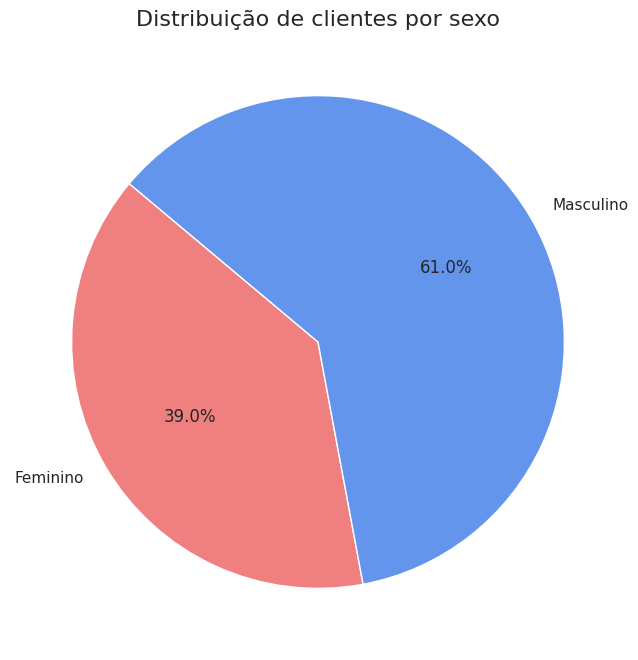

In [ ]:
# criando um df da query para construção do gráfico
df = pd.read_sql_query(select_query, banco)
sns.set(style='whitegrid')

fig, ax = plt.subplots(figsize=(8,8))
ax.pie(df['total_clientes'],
       labels=['Masculino' if x =='M' else 'Feminino' for x in df['sexo']],
       autopct='%1.1f%%',
       startangle=140,
       colors=
        ['cornflowerblue' if x == 'M' else 'lightcoral' for x in df['sexo']])
plt.title('Distribuição de clientes por sexo', size=16)

plt.show()

In [ ]:
# conferindo qual a idade mínima de máxima para definição da faixa etária
select_query = '''
SELECT
MIN(idade) AS idade_minima,
MAX(idade) AS idade_maxima
FROM credito;
'''
execute_query(select_query)

|   idade_minima |   idade_maxima |
|---------------:|---------------:|
|             26 |             73 |


Para melhor visualizar como está a distribuição de idade e sexo utilizarei o gráfico de [pirâmide etária](https://www.youtube.com/watch?v=lOOf1aokYPc&t=6s), onde conseguiremos ver ao mesmo tempo ambos os sexos. Para construção do gráfico criei uma nova tabela onde serão registrados por faixas de idade (sendo a idade mínima de 25 anos e máxima de 75, e tendo como intervalo 5 anos).

In [ ]:
select_query = '''
CREATE TABLE IF NOT EXISTS total_sexo_faixa_etaria AS
SELECT
  idade,
  sexo,
CASE
  WHEN idade BETWEEN 25 AND 29 THEN '25 a 29 anos'
  WHEN idade BETWEEN 30 AND 34 THEN '30 a 34 anos'
  WHEN idade BETWEEN 35 AND 39 THEN '35 a 39 anos'
  WHEN idade BETWEEN 40 AND 44 THEN '40 a 44 anos'
  WHEN idade BETWEEN 45 AND 49 THEN '45 a 49 anos'
  WHEN idade BETWEEN 50 AND 54 THEN '50 a 54 anos'
  WHEN idade BETWEEN 55 AND 59 THEN '55 a 59 anos'
  WHEN idade BETWEEN 60 AND 64 THEN '60 a 64 anos'
  WHEN idade BETWEEN 65 AND 69 THEN '65 a 69 anos'
  WHEN idade BETWEEN 70 AND 74 THEN '70 a 74 anos'
  END AS faixa_etaria
FROM
    credito;
'''
cursor.execute(select_query)

In [ ]:
# a nova tabela se chama 'total_sexo_faixa_etaria'
select_query='''
SELECT * FROM total_sexo_faixa_etaria
limit 10;
'''
execute_query(select_query)

|   idade | sexo   | faixa_etaria   |
|--------:|:-------|:---------------|
|      45 | M      | 45 a 49 anos   |
|      49 | F      | 45 a 49 anos   |
|      51 | M      | 50 a 54 anos   |
|      40 | F      | 40 a 44 anos   |
|      40 | M      | 40 a 44 anos   |
|      44 | M      | 40 a 44 anos   |
|      51 | M      | 50 a 54 anos   |
|      32 | M      | 30 a 34 anos   |
|      37 | M      | 35 a 39 anos   |
|      48 | M      | 45 a 49 anos   |


In [ ]:
select_query = '''
SELECT
    faixa_etaria,
    SUM(CASE WHEN sexo = 'M' THEN 1 ELSE 0 END) AS total_masculino,
    SUM(CASE WHEN sexo = 'F' THEN 1 ELSE 0 END) AS total_feminino
FROM total_sexo_faixa_etaria
GROUP BY faixa_etaria;
'''
execute_query(select_query)

| faixa_etaria   |   total_masculino |   total_feminino |
|:---------------|------------------:|-----------------:|
| 25 a 29 anos   |                66 |               41 |
| 30 a 34 anos   |               141 |               77 |
| 35 a 39 anos   |               300 |              199 |
| 40 a 44 anos   |               211 |              124 |
| 45 a 49 anos   |               264 |              143 |
| 50 a 54 anos   |               250 |              175 |
| 55 a 59 anos   |               226 |              135 |
| 60 a 64 anos   |                78 |               72 |
| 65 a 69 anos   |                25 |               35 |
| 70 a 74 anos   |                 2 |                0 |


In [ ]:
# criando um df com a query para confecção do gráfico
df = pd.read_sql_query(select_query, banco)
print(df)

   faixa_etaria  total_masculino  total_feminino
0  25 a 29 anos               66              41
1  30 a 34 anos              141              77
2  35 a 39 anos              300             199
3  40 a 44 anos              211             124
4  45 a 49 anos              264             143
5  50 a 54 anos              250             175
6  55 a 59 anos              226             135
7  60 a 64 anos               78              72
8  65 a 69 anos               25              35
9  70 a 74 anos                2               0


In [ ]:
# invertendo valores masculino para o gráfico
df['total_masculino'] = df['total_masculino']*-1

In [ ]:
# criando lista para legenda do gráfico
idades=['70 a 74 anos',
        '65 a 69 anos',
        '60 a 64 anos',
        '55 a 59 anos',
        '50 a 54 anos',
        '45 a 49 anos',
        '40 a 44 anos',
        '35 a 39 anos',
        '30 a 34 anos',
        '25 a 29 anos']

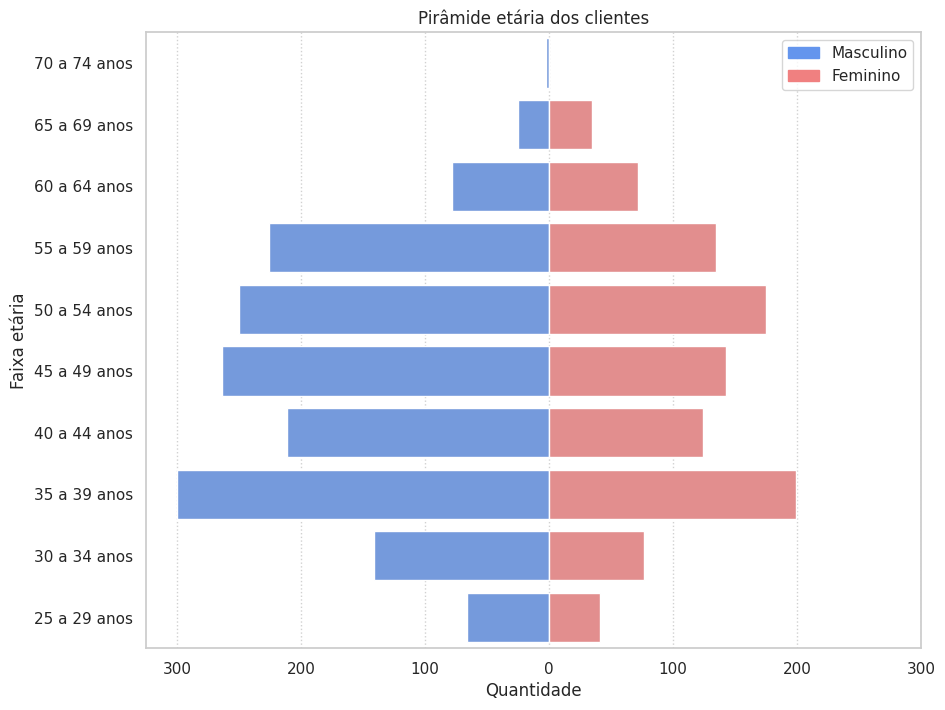

In [ ]:
plt.figure(figsize=(10,8))
# gráfico masculino
ax1 = sns.barplot(
    x='total_masculino',
    y='faixa_etaria',
    order=idades,
    data=df,
    color='cornflowerblue')
# gráfico feminino
ax2 = sns.barplot(
    x='total_feminino',
    y='faixa_etaria',
    order=idades,
    data=df,
    color='lightcoral')
plt.title('Pirâmide etária dos clientes')
plt.xlabel('Quantidade')
plt.ylabel('Faixa etária')
plt.grid(False)

# invertendo sinal da legenda
plt.xticks(ticks=[-300, -200, -100, 0, 100, 200, 300],
labels = ['300', '200', '100', '0', '100', '200','300'])
plt.grid(axis='x', linestyle=':', alpha=0.9)

# legenda
masculino_patch = Patch(color='cornflowerblue', label='Masculino')
feminino_patch = Patch(color='lightcoral', label='Feminino')
plt.legend(handles=[masculino_patch, feminino_patch], loc='upper right')

Podemos ver que 61% dos clientes são homens, estando o maior número  na faixa dos 35 aos 39 anos, havendo também um quantidade semelhante de cliente homens nas faixa dos 45 aos 59. Já as mulheres representam 39% dos cliente, tendo a faixa etária mais comum dentre os 35 aos 39 e havendo um número próximo na faixa de 50 à 54 anos.
Em ambos os sexos existe uma queda no número de clientes exatamente na faixa dos 40 aos 44 anos, podendo ser analisado mais a fundo em como eles utilizam o cartão e até mesmo estudar em como melhorar o produto (cartão de crédito) especificamente para os usos dessa faixa etária.

## Relação entre escolaridade e salário anual

Nesse tópico quero abordar como a escolaridade influência no saário anual dos clientes. Para que assim possamos identificar como os diferentes níveis de escolaridade têm potêncial financeiro para utilizarem o cartão, ou até mesmo para aumentar limites e criar novos produtos para determinando tipo de cliente. Como referência utilizarei o gráfico de [barras empilhadas](https://medium.com/horadecodar/gr%C3%A1ficos-de-barra-com-matplotlib-85628bfc4351) por percentual para [visualizar os salários](https://www.moneytimes.com.br/de-r-33-mil-a-r-165-mil-quanto-ganham-profissionais-de-marketing-digital-e-desenvolvimento/) de cada nível.



In [ ]:
select_query='''
SELECT
  escolaridade,
  salario_anual AS media_salario
FROM credito
GROUP BY escolaridade
ORDER BY media_salario DESC;
'''
execute_query(select_query)

| escolaridade        | media_salario   |
|:--------------------|:----------------|
| mestrado            | menos que $40K  |
| graduacao           | $80K - $120K    |
| doutorado           | $80K - $120K    |
| sem educacao formal | $60K - $80K     |
| ensino medio        | $60K - $80K     |
| na                  | $120K +         |


In [ ]:
select_query = '''
SELECT
  escolaridade,
  salario_anual,
  count (*) AS count_salario
FROM credito
GROUP BY
  escolaridade,
  salario_anual;
'''
execute_query(select_query)

| escolaridade        | salario_anual   |   count_salario |
|:--------------------|:----------------|----------------:|
| doutorado           | $120K +         |              36 |
| doutorado           | $40K - $60K     |              80 |
| doutorado           | $60K - $80K     |              90 |
| doutorado           | $80K - $120K    |              86 |
| doutorado           | menos que $40K  |             124 |
| doutorado           | na              |              54 |
| ensino medio        | $120K +         |              98 |
| ensino medio        | $40K - $60K     |             214 |
| ensino medio        | $60K - $80K     |             216 |
| ensino medio        | $80K - $120K    |             196 |
| ensino medio        | menos que $40K  |             266 |
| ensino medio        | na              |             100 |
| graduacao           | $120K +         |              58 |
| graduacao           | $40K - $60K     |              86 |
| graduacao           | $60K - $80K     

In [ ]:
# pivotando as colunas
select_query = '''
SELECT
  escolaridade,
  na,
  menos_que_40k,
  entre_40k_60k,
  entre_60k_80k,
  entre_80k_120k,
  acima_120k,
  total_por_linha
FROM (
  SELECT
    escolaridade,
    SUM(CASE WHEN salario_anual = 'na' THEN count_salario ELSE 0 END) AS na,
    SUM(CASE WHEN salario_anual = 'menos que $40K'
      THEN count_salario ELSE 0 END) AS menos_que_40k,
    SUM(CASE WHEN salario_anual = '$40K - $60K'
      THEN count_salario ELSE 0 END) AS entre_40k_60k,
    SUM(CASE WHEN salario_anual = '$60K - $80K'
      THEN count_salario ELSE 0 END) AS entre_60k_80k,
    SUM(CASE WHEN salario_anual = '$80K - $120K'
      THEN count_salario ELSE 0 END) AS entre_80k_120k,
    SUM(CASE WHEN salario_anual = '$120K +'
      THEN count_salario ELSE 0 END) AS acima_120k,
    SUM(count_salario) AS total_por_linha
  FROM (
    SELECT
      escolaridade,
      salario_anual,
      COUNT(*) AS count_salario
    FROM credito
    GROUP BY escolaridade, salario_anual
    ) AS counts
GROUP BY
escolaridade
) AS counts_with_total
ORDER BY
  CASE escolaridade
    WHEN 'doutorando' THEN 1
    WHEN 'mestrado' THEN 2
    WHEN 'graduacao' THEN 3
    WHEN 'ensino medio' THEN 4
    WHEN 'sem educacao formal' THEN 5
    WHEN 'na' THEN 6
END;
'''
execute_query(select_query)

| escolaridade        |   na |   menos_que_40k |   entre_40k_60k |   entre_60k_80k |   entre_80k_120k |   acima_120k |   total_por_linha |
|:--------------------|-----:|----------------:|----------------:|----------------:|-----------------:|-------------:|------------------:|
| doutorado           |   54 |             124 |              80 |              90 |               86 |           36 |               470 |
| mestrado            |  140 |             478 |             284 |             270 |              324 |          124 |              1620 |
| graduacao           |   36 |             138 |              86 |              88 |              116 |           58 |               522 |
| ensino medio        |  100 |             266 |             214 |             216 |              196 |           98 |              1090 |
| sem educacao formal |   72 |             220 |             142 |             114 |              128 |           58 |               734 |
| na                  |   6

In [ ]:
#select_query='select escolaridade, salario_anual from credito' # nao apagar isso, tudo depende disso
df = pd.read_sql_query(select_query, banco)
df

,escolaridade,na,menos_que_40k,entre_40k_60k,entre_60k_80k,entre_80k_120k,acima_120k,total_por_linha
0,doutorado,54,124,80,90,86,36,470
1,mestrado,140,478,284,270,324,124,1620
2,graduacao,36,138,86,88,116,58,522
3,ensino medio,100,266,214,216,196,98,1090
4,sem educacao formal,72,220,142,114,128,58,734
5,na,68,176,128,124,126,70,692


In [ ]:
# renomeando as coluns para a legenda do gráfico
df.columns = ['Escolaridade',
              'Não Informado',
              'Menos de 40K',
              'Entre 40K e 60K',
              'Entre 60K e 80K',
              'Entre 80K e 120K',
              'Acima de 120K',
              'Total por Escolaridade']

In [ ]:
# renomeando as linhas para confecção do gráfico
nomes_escolaridades = ['Doutorado',
                       'Mestrado',
                       'Graduação',
                       'Ensino Médio',
                       'Sem Escolaridade',
                       'Não Informado']
df.loc[:5,'Escolaridade'] = nomes_escolaridades

In [ ]:
# criando funcão para converter valores absolutos em porcentagem
def transform_to_percentage(df):
    columns_to_transform = ['Não Informado',
                            'Menos de 40K',
                            'Entre 40K e 60K',
                            'Entre 60K e 80K',
                            'Entre 80K e 120K',
                            'Acima de 120K',
                            'Total por Escolaridade']
    for col in columns_to_transform:
        df[col] = round(((df[col] / df['Total por Escolaridade']) * 100),2)
    return df

# aplicando a função
df_transformed = transform_to_percentage(df)

# selecionando apenas colunas de porcentagens e escolaridade
df = df_transformed[['Escolaridade',
                     'Não Informado',
                     'Menos de 40K',
                     'Entre 40K e 60K',
                     'Entre 60K e 80K',
                     'Entre 80K e 120K',
                     'Acima de 120K',
                     'Total por Escolaridade']]
df = df.iloc[::-1].reset_index(drop=True) # invertendo a ordem para o grafico
df

,Escolaridade,Não Informado,Menos de 40K,Entre 40K e 60K,Entre 60K e 80K,Entre 80K e 120K,Acima de 120K,Total por Escolaridade
0,Não Informado,9.83,25.43,18.50,17.92,18.21,10.12,100.0
1,Sem Escolaridade,9.81,29.97,19.35,15.53,17.44,7.90,100.0
2,Ensino Médio,9.17,24.40,19.63,19.82,17.98,8.99,100.0
3,Graduação,6.90,26.44,16.48,16.86,22.22,11.11,100.0
4,Mestrado,8.64,29.51,17.53,16.67,20.00,7.65,100.0
5,Doutorado,11.49,26.38,17.02,19.15,18.30,7.66,100.0


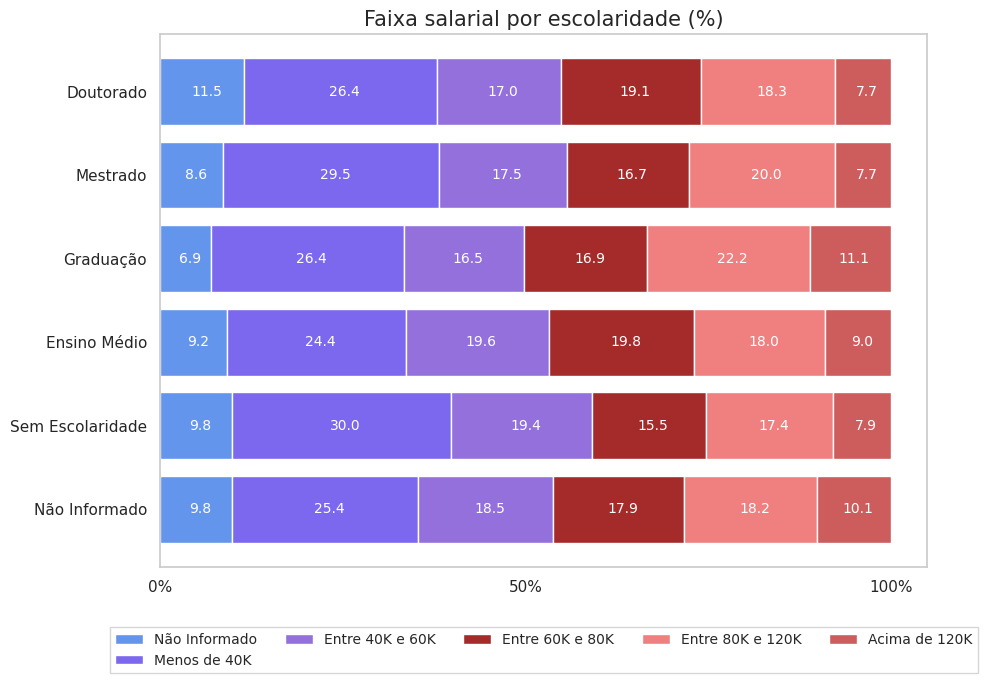

In [ ]:
# criando listas para categorias e cores do gráfico
categories = ['Não Informado',
              'Menos de 40K',
              'Entre 40K e 60K',
              'Entre 60K e 80K',
              'Entre 80K e 120K',
              'Acima de 120K',
              'Total por Escolaridade']
colors = ['#6495ED', '#7B68EE', '#9370DB', '#A52A2A', '#F08080', '#CD5C5C']

fig, ax = plt.subplots(figsize=(10, 7))
bottom_values = [0] * len(df)
for category, color in zip(categories, colors):
    bars = ax.barh(
        df['Escolaridade'],
        df[category],
        left=bottom_values,
        label=category,
        color=color)
    for bar, value in zip(bars, df[category]):
        ax.annotate(
            f'{round(value,1)}',
            xy=(bar.get_x()+bar.get_width()/2, bar.get_y()+bar.get_height()/2),
            xytext=(3, 0),  # Deslocamento do texto
            textcoords="offset points",
            ha='center', va='center', color='white', fontsize=10)
    bottom_values = [i + j for i, j in zip(bottom_values, df[category])]

# configurando as legendas
plt.xticks([0, 50, 100], ['0%', '50%', '100%'])
ax.set_title('Faixa salarial por escolaridade (%)', fontsize=15)
ax.legend(loc='upper center',
          bbox_to_anchor=(0.5, -0.10),
          ncol=5,
          fontsize='small',
          fancybox=False)
ax.grid(False)

plt.tight_layout()
plt.show()

Primeiramente, gostaria de destacar minha decisão de deixar os valores como 'na' tanto para a escolaridade quanto para a faixa salarial. Isso se deve ao fato de não ter conhecimento sobre como ocorre a coleta dos dados. Clientes que optam por não informar sua escolaridade ou salário podem ter motivos pessoais para isso, o que pode fornecer insights sobre suas decisões. Além disso, pode ser que durante a coleta de dados tenha ocorrido uma falha que permitiu ao cliente não fornecer essas informações, seja por falha no sistema de cadastro ou por erro humano. Em ambos os casos, considerei interessante manter esses dados para possibilitar a geração de insights relevantes.

Continuando com a análise do gráfico, observamos que a relação entre salário e escolaridade parece seguir uma distribuição padrão, mais influenciada pela faixa salarial do que pela escolaridade em si. Em outras palavras, independentemente da escolaridade, a composição percentual dos clientes parece seguir uma referência: metade dos clientes ganha até \$60K anuais e a outra metade ganha acima desse valor. No entanto, mesmo com certo grau de homogeneização nos salários, clientes com Graduação tendem a ter rendimentos ligeiramente superiores. Nota-se que aqueles sem escolaridade que ganham entre \$40K e \$60K anuais representam 30%, enquanto os clientes com 'mestrado' e 'doutorado' que ganham mais de \$120K anuais representam apenas 7,7% cada.

## Perfil do uso do cartão

Com nossa base de dados, podemos explorar diferentes perfis de uso do cartão, especialmente ao caracterizar o comportamento de acordo com a faixa salarial. Essa análise se concentra em relacionar o ticket médio (valor médio gasto em cada compra) com o limite do cartão. Optei por essa abordagem devido às diferentes formas de utilização do cartão associadas às rendas variadas. Avaliar como o valor médio das compras se relaciona com o limite disponível permite uma análise mais precisa do potencial de compra e do uso eficaz do crédito.


In [ ]:
# calculando o ticket medio e o df
select_query = '''
SELECT salario_anual,
       round(avg(limite_credito),2) as limite_media,
       SUM(valor_transacoes_12m) / SUM(qtd_transacoes_12m) AS ticket_medio
FROM credito
WHERE salario_anual <> 'na'
GROUP BY salario_anual;
'''
execute_query(select_query)
df = pd.read_sql_query(select_query, banco)

| salario_anual   |   limite_media |   ticket_medio |
|:----------------|---------------:|---------------:|
| $120K +         |       17801.5  |        42.7049 |
| $40K - $60K     |        5348.36 |        43.7014 |
| $60K - $80K     |        9096.03 |        44.2517 |
| $80K - $120K    |       14886.6  |        43.3966 |
| menos que $40K  |        4099.48 |        43.4951 |


In [ ]:
df.head(10)

,salario_anual,limite_media,ticket_medio
0,$120K +,17801.49,42.704950
1,$40K - $60K,5348.36,43.701356
2,$60K - $80K,9096.03,44.251685
3,$80K - $120K,14886.56,43.396592
4,menos que $40K,4099.48,43.495099


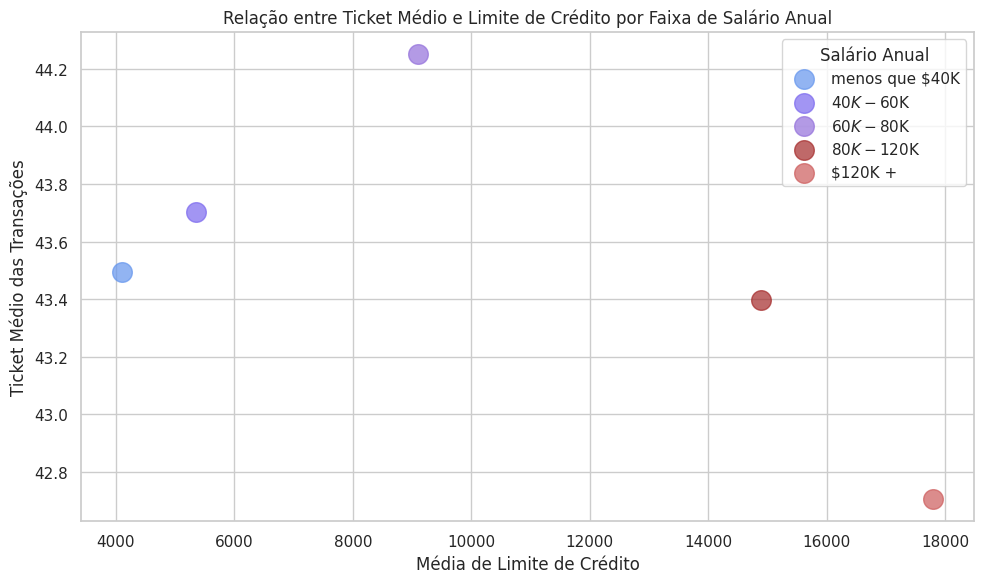

In [ ]:
# criando listas para categorias e cores do gráfico
categories = ['menos que $40K', '$40K - $60K', '$60K - $80K', '$80K - $120K', '$120K +']
colors = ['#6495ED', '#7B68EE', '#9370DB', '#A52A2A', '#CD5C5C']
cores = dict(zip(categories, colors))

plt.figure(figsize=(10, 6))

for salario in cores:
    subset = df[df['salario_anual'] == salario]
    plt.scatter(subset['limite_media'],
                subset['ticket_medio'],
                s=200, c=cores[salario],
                label=salario,
                alpha=0.7)

# configurando rótulos e título do gráfico
plt.xlabel('Média de Limite de Crédito')
plt.ylabel('Ticket Médio das Transações')
plt.title('Relação entre Ticket Médio e Limite de Crédito por Faixa de Salário Anual')
plt.legend(title='Salário Anual', loc='upper right')

plt.grid(True)
plt.tight_layout()
plt.show()

Como podemos observar neste gráfico, a relação entre o ticket médio e o limite de crédito segue dois padrões distintos: o primeiro é uma relação positiva, onde quanto maior o limite, maior é o ticket médio. Isso é evidente nas faixas salariais de \$40K até \$80K anuais. O segundo padrão é negativo, onde o ticket médio tende a diminuir com o aumento do limite, especialmente nas faixas salariais acima de \$80K anuais.

Diante desses padrões, podemos definir dois tipos de clientes com diferentes comportamentos de gastos: aqueles que utilizam o crédito de forma mais intensa e aumentam seus gastos conforme o limite disponível, e aqueles que, apesar do maior limite, mantêm ou diminuem seus gastos médios. Essa segmentação permite uma abordagem mais precisa na oferta de serviços e produtos financeiros, alinhados às necessidades e comportamentos de cada grupo.

# Conclusão

Este projeto demonstrou não apenas a aplicação eficaz da linguagem SQL na análise de dados de clientes de cartão de crédito, mas também a flexibilidade em adaptar estratégias conforme as necessidades surgem. Inicialmente exploramos ferramentas em nuvem como AWS S3 e Athena, mas optamos por um ambiente local para facilitar a interatividade e documentação do processo. A análise revelou padrões significativos na relação entre faixa salarial, escolaridade, gastos e limite de crédito dos clientes, permitindo uma segmentação precisa. Esses insights são fundamentais para orientar decisões estratégicas em serviços financeiros e áreas correlatas, reforçando a importância da análise de dados no contexto empresarial.